In [33]:
# Senior Age Prediction Hackathon Notebook
#Author: Sai Krishna
#Version: Final Submission
#Date: 23-06-2025

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')


In [4]:
# load Datasets
train_df = pd.read_csv('/content/Train_Data.csv')
test_df = pd.read_csv('/content/Test_Data.csv')
sample_submission = pd.read_csv('/content/Sample_Submission.csv')

In [5]:
# Data Overview
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)
print("\nTraining Data Sample:")
print(train_df.head())

Training Data Shape: (1966, 9)
Testing Data Shape: (312, 8)

Training Data Sample:
      SEQN  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN age_group
0  73564.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91     Adult
1  73568.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85     Adult
2  73576.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14     Adult
3  73577.0       1.0     2.0    28.9   104.0     NaN    84.0  16.15     Adult
4  73580.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92     Adult


In [6]:
# Dataset information
print("\nTraining Data Info:")
print(train_df.info())
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIAGENDR   1948 non-null   float64
 2   PAQ605     1953 non-null   float64
 3   BMXBMI     1948 non-null   float64
 4   LBXGLU     1953 non-null   float64
 5   DIQ010     1948 non-null   float64
 6   LBXGLT     1955 non-null   float64
 7   LBXIN      1957 non-null   float64
 8   age_group  1952 non-null   object 
dtypes: float64(8), object(1)
memory usage: 138.4+ KB
None

Missing Values in Training Data:
SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64


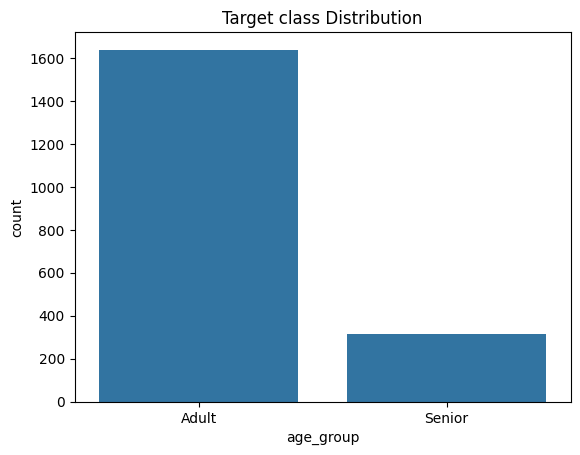

In [7]:
# Visualize Class Distribution
sns.countplot(x = 'age_group', data = train_df)
plt.title("Target class Distribution")
plt.show()

In [8]:
# Drop Identifier
train_df.drop('SEQN', axis = 1, inplace = True)
test_ids = test_df['SEQN']
test_df.drop('SEQN', axis = 1, inplace = True)

In [9]:
# Encode target variable
le_target = LabelEncoder()
train_df['age_group'] = le_target.fit_transform(train_df['age_group'])

In [10]:
# Handling Missing values
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']

In [11]:
num_imputer = SimpleImputer(strategy = 'median')
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

In [12]:
cat_imputer = SimpleImputer(strategy = 'most_frequent')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

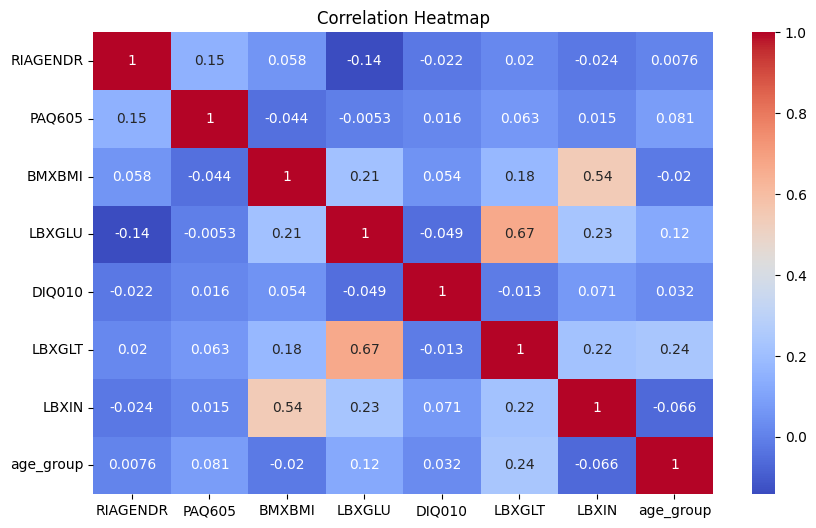

In [13]:
# Correlation heatmap
plt.figure(figsize = (10, 6))
sns.heatmap(train_df.corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# Feature engineering - BMI category
def bmi_category(bmi):
  if bmi < 18.5:
    return 0   # underweight
  elif bmi < 25:
    return 1   # normal
  elif bmi < 30:
    return 2   # Overweight
  else:
    return 3   # obese

In [15]:
train_df['BMI_category'] = train_df['BMXBMI'].apply(bmi_category)
test_df['BMI_category'] = test_df['BMXBMI'].apply(bmi_category)

In [16]:
# scaling numerical features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [19]:
# One Hot Encode Categorical Features
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
ohe_cols = ['RIAGENDR','PAQ605','DIQ010']

In [20]:
train_ohe = pd.DataFrame(ohe.fit_transform(train_df[ohe_cols]), columns=ohe.get_feature_names_out())
test_ohe = pd.DataFrame(ohe.transform(test_df[ohe_cols]), columns=ohe.get_feature_names_out())

In [21]:
train_df = train_df.drop(ohe_cols, axis = 1).reset_index(drop = True)
test_df = test_df.drop(ohe_cols, axis = 1).reset_index(drop = True)
train_df = pd.concat([train_df, train_ohe], axis=1)
test_df = pd.concat([test_df, test_ohe], axis=1)

In [22]:
# prepare data for Model
X_train = train_df.drop('age_group', axis = 1)
y_train = train_df['age_group']

In [23]:
# check class balance
class_counts = y_train.value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]
print("Class Balance:")
print(class_counts)
print(f"Imbalance Ratio (Adult/Senior): {imbalance_ratio:.2f}")

Class Balance:
age_group
0    1638
1     314
2      14
Name: count, dtype: int64
Imbalance Ratio (Adult/Senior): 5.22


In [24]:
# hyperparameter tuning with Cross-Validation
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, imbalance_ratio]
}

In [25]:
base_model = XGBClassifier(use_label_encoder = False, eval_metrics ='logloss', random_state = 42 )
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [26]:
search = RandomizedSearchCV(
    estimator = base_model,
    param_distributions = param_grid,
    n_iter = 10,
    scoring = 'f1',
    cv = skf,
    random_state = 42
)
search.fit(X_train, y_train)
print("Best Hyperparameters:", search.best_params_)
model = search.best_estimator_

Best Hyperparameters: {'subsample': 0.7, 'scale_pos_weight': np.float64(5.2165605095541405), 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}


In [27]:
# Evaluate model with Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_weighted')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Average CV F1 Score: {cv_scores.mean():.4f}")


Cross-Validation F1 Scores: [0.80082168 0.78610191 0.79717289 0.79015951 0.8139628 ]
Average CV F1 Score: 0.7976


Training Accuracy: 0.9461
Training F1 Score: 0.9412


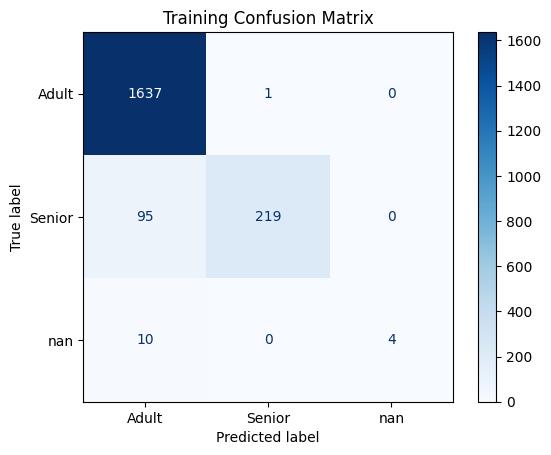

In [28]:
# Evaluate model on Full Training Set
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)
disp.plot(cmap='Blues')
plt.title('Training Confusion Matrix')
plt.show()


100%|===================| 5877/5898 [01:20<00:00]       

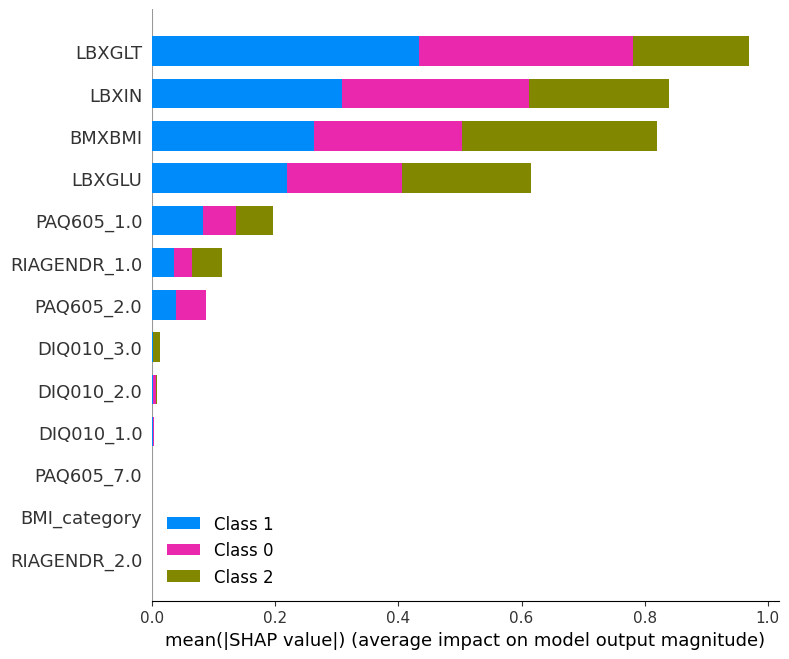

In [29]:
# Feature importance with SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


In [30]:
# Predict on Test data
y_pred = model.predict(test_df)

In [31]:
# preparing submission File
submission = sample_submission.copy()
submission['age_group'] = y_pred
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' generated successfully!")

Submission file 'submission.csv' generated successfully!
